# Các thành viên trong nhóm 5:
- 21064051 Nguyễn Hùng Anh
- 21075071 Nguyễn Hạnh Bảo Ân
- 21090261 Dương Ngọc Anh
- 21073141 Lê Phú Hào

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## I. Mục tiêu chính
- Sử dụng mô hình FE-ELM (Feature Ensemble - Extreme Learning Machine) để phân loại dữ liệu mảng cảm biến khí (GSA) trong điều kiện khí có nồng độ thấp.

Xem trước nội dung

In [10]:
import pandas as pd

# Đọc dữ liệu từ tệp CSV
file_path = "/content/drive/MyDrive/NDM/gsalc.csv"
df = pd.read_csv(file_path)

# Xem trước 5 dòng đầu tiên
df.head()

,ethanol,100ppb,0.3565,0.3345,0.3575,0.333,0.3565.1,0.3345.1,0.3565.2,0.3355,...,3.93.74,3.929.105,3.929.106,3.929.107,3.9315.53,3.935.12,3.9275.108,3.93.75,3.9325.24,3.9315.54
0,ethanol,100ppb,0.3525,0.3305,0.3525,0.3320,0.3550,0.3305,0.3525,0.3280,...,3.9190,3.9190,3.9180,3.9180,3.9180,3.9180,3.9190,3.918,3.9180,3.9205
1,ethanol,100ppb,0.3550,0.3345,0.3540,0.3320,0.3550,0.3330,0.3550,0.3320,...,3.8815,3.8840,3.8800,3.8800,3.8840,3.8840,3.8815,3.884,3.8825,3.8815
2,ethanol,100ppb,0.3415,0.3220,0.3430,0.3210,0.3430,0.3235,0.3415,0.3210,...,3.9460,3.9485,3.9410,3.9470,3.9460,3.9425,3.9460,3.946,3.9460,3.9460
3,ethanol,100ppb,0.3500,0.3245,0.3465,0.3320,0.3455,0.3245,0.3490,0.3235,...,3.9375,3.9400,3.9385,3.9375,3.9375,3.9365,3.9400,3.940,3.9365,3.9365
4,ethanol,200ppb,0.3380,0.3220,0.3365,0.3345,0.3380,0.3365,0.3380,0.3210,...,3.8730,3.8705,3.8715,3.8715,3.8730,3.8705,3.8715,3.874,3.8680,3.8730


Kiểm tra kích thước dữ liệu, tên cột, dữ liệu thiếu

In [11]:
# Kiểm tra kích thước dữ liệu
num_rows, num_cols = df.shape

# Kiểm tra tên cột
column_names = df.columns[:10]  # Lấy 10 cột đầu tiên để xem xét

# Kiểm tra giá trị bị thiếu
missing_values = df.isnull().sum().sum()

# In thông tin về dữ liệu
print(f"- Số lượng mẫu (dòng): {num_rows}")
print(f"- Số lượng đặc trưng (cột): {num_cols}")
print(f"- Tên 10 cột đầu tiên: {list(column_names)}")
print(f"- Số lượng giá trị bị thiếu: {missing_values}")


- Số lượng mẫu (dòng): 89
- Số lượng đặc trưng (cột): 9002
- Tên 10 cột đầu tiên: ['ethanol', '100ppb', '0.3565', '0.3345', '0.3575', '0.333', '0.3565.1', '0.3345.1', '0.3565.2', '0.3355']
- Số lượng giá trị bị thiếu: 0


1. Cấu trúc của từng hàng trong tệp `gsalc.csv`

| Cột      | Nội dung |
|----------|---------|
| **Cột 1**  | Nhãn khí (*ethanol, acetone, toluene, etc.*) → **Nhãn phân loại** |
| **Cột 2**  | Nồng độ khí (*50ppb, 100ppb, 200ppb*) → **Có thể dùng làm đặc trưng hoặc phân tích thêm** |
| **Cột 3-9002** | Phản ứng của 10 cảm biến với khí (mỗi cảm biến có 900 điểm dữ liệu) → **Đặc trưng đầu vào** |


2. Định dạng dữ liệu mẫu
- 📌 **Có tổng cộng 90 mẫu** (tương ứng với 90 dòng dữ liệu).  
- 📌 **Có 6 loại khí x 3 mức nồng độ x 5 lần lặp lại = 90 mẫu**.  
- 📌 **Dữ liệu phản ứng cảm biến được chia thành 10 khối**, mỗi khối có **900 điểm cho 1 cảm biến**.


## II. Tiền Xử Lý Dữ Liệu


In [12]:
import numpy as np

# Đổi tên cột: Cột 1 là 'Gas', Cột 2 là 'Concentration', Còn lại là các chỉ số từ 0 đến 8999
df.columns = ['Gas', 'Concentration'] + list(range(9000))

# Kiểm tra giá trị thiếu
missing_values = df.isnull().sum().sum()

# Chuyển đổi nhãn khí và nồng độ thành dạng số
gas_labels = {gas: i for i, gas in enumerate(df['Gas'].unique())}
concentration_labels = {conc: i for i, conc in enumerate(df['Concentration'].unique())}

df['Gas'] = df['Gas'].map(gas_labels)
df['Concentration'] = df['Concentration'].map(concentration_labels)

# Chuẩn hóa dữ liệu cảm biến (Min-Max scaling)
sensor_data = df.iloc[:, 2:].values  # Bỏ 2 cột đầu
sensor_data = (sensor_data - sensor_data.min()) / (sensor_data.max() - sensor_data.min())

# Gán lại vào DataFrame
df.iloc[:, 2:] = sensor_data


In [13]:
from scipy.stats import skew, kurtosis

# Trích xuất đặc trưng từ mỗi mẫu (9000 điểm) cho 10 cảm biến
def extract_features(sensor_data):
    features = []
    for i in range(10):  # 10 cảm biến
        start = i * 900
        end = (i + 1) * 900
        segment = sensor_data[:, start:end]
        features.append(np.mean(segment, axis=1))    # Trung bình
        features.append(np.std(segment, axis=1))     # Độ lệch chuẩn
        features.append(skew(segment, axis=1))       # Độ lệch
        features.append(kurtosis(segment, axis=1))   # Độ nhọn
    return np.column_stack(features)

# Áp dụng trích xuất đặc trưng
X = extract_features(sensor_data)
y = df['Gas'].values  # Nhãn khí

# Kiểm tra kích thước dữ liệu sau trích xuất
X.shape, y.shape


((89, 40), (89,))

## III.Huấn luyện mô hình FE-ELM

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report

# Chia dữ liệu (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Chuẩn hóa dữ liệu (Standardization)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Huấn luyện mô hình FE-ELM (MLP với một hidden layer)
model = MLPClassifier(hidden_layer_sizes=(50,), activation='relu', solver='adam', max_iter=1000, random_state=42)
model.fit(X_train, y_train)

# Dự đoán trên tập kiểm tra
y_pred = model.predict(X_test)


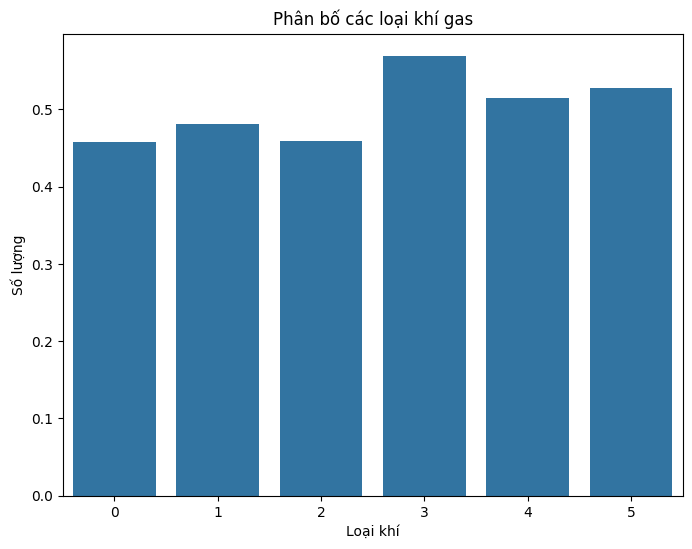

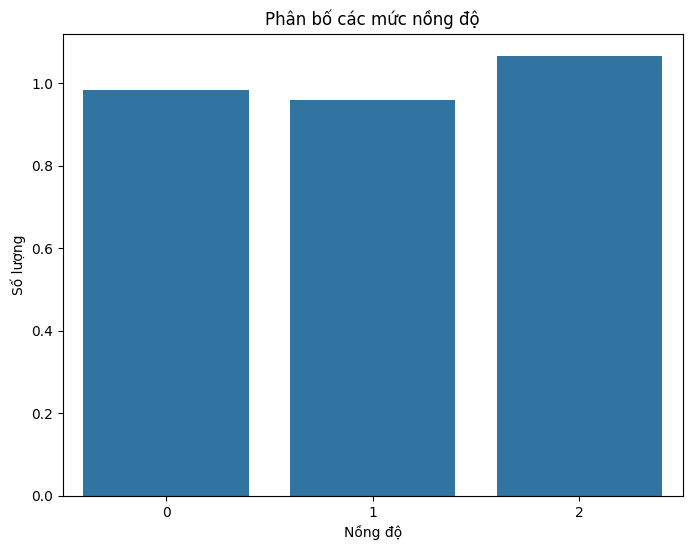

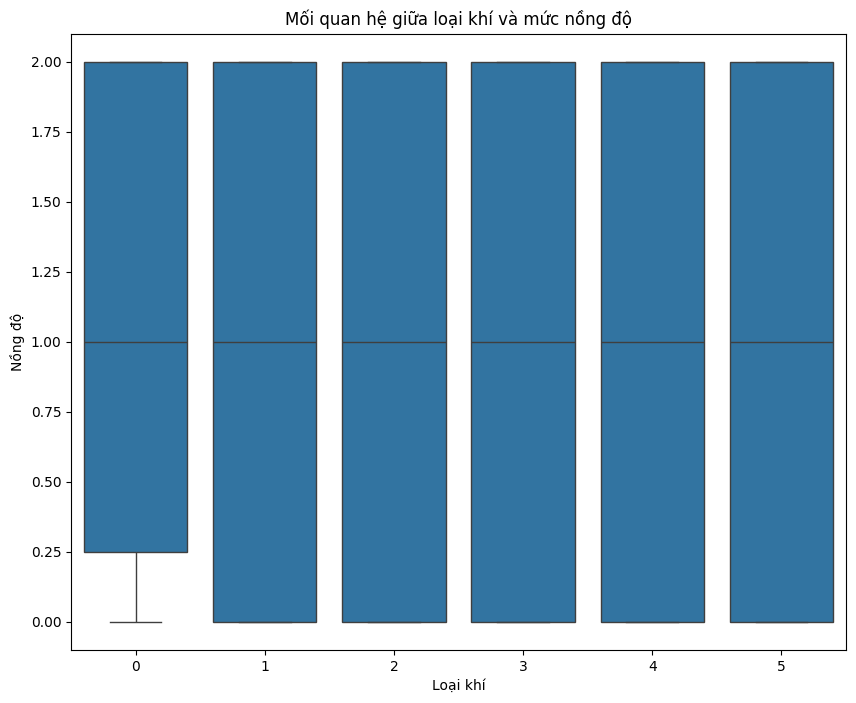

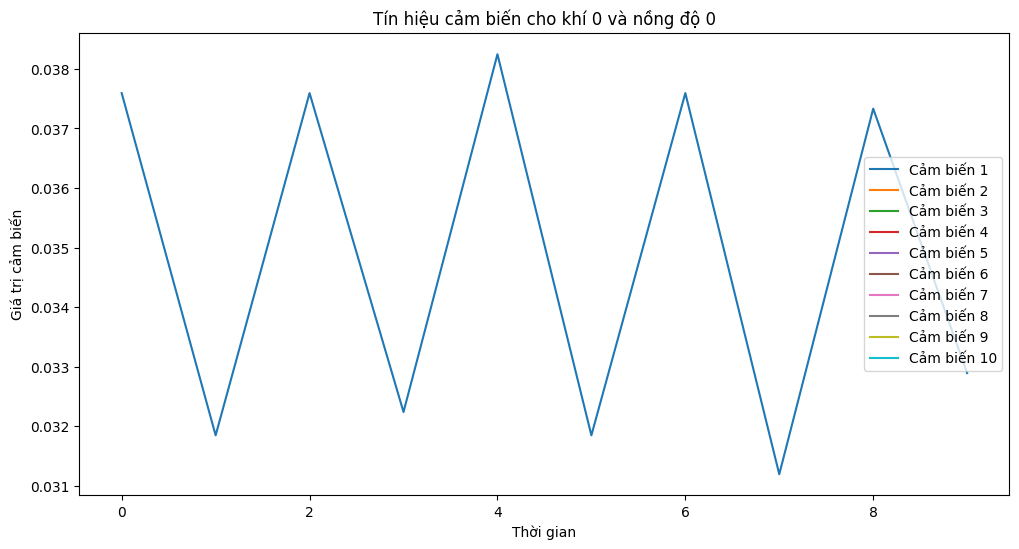

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Trực quan hóa phân bố các nhãn khí gas
plt.figure(figsize=(8, 6))
sns.countplot(x='Gas', data=df)
plt.title('Phân bố các loại khí gas')
plt.xlabel('Loại khí')
plt.ylabel('Số lượng')
plt.show()

# Trực quan hóa phân bố các mức nồng độ
plt.figure(figsize=(8, 6))
sns.countplot(x='Concentration', data=df)
plt.title('Phân bố các mức nồng độ')
plt.xlabel('Nồng độ')
plt.ylabel('Số lượng')
plt.show()

# Trực quan hóa mối quan hệ giữa loại khí và nồng độ
plt.figure(figsize=(10, 8))
sns.boxplot(x='Gas', y='Concentration', data=df)
plt.title('Mối quan hệ giữa loại khí và mức nồng độ')
plt.xlabel('Loại khí')
plt.ylabel('Nồng độ')
plt.show()

# Trực quan hóa 10 cảm biến đầu tiên cho một loại khí và nồng độ cụ thể
chi_so_khi = 0            # Thay bằng chỉ số khí mong muốn
chi_so_nong_do = 0        # Thay bằng chỉ số nồng độ mong muốn

du_lieu_khi = df[(df['Gas'] == chi_so_khi) & (df['Concentration'] == chi_so_nong_do)]
doc_cam_bien = du_lieu_khi.iloc[:, 2:12].values  # Lấy 10 cảm biến đầu tiên

plt.figure(figsize=(12, 6))
for i in range(10):
    plt.plot(doc_cam_bien[0, i*900:(i+1)*900], label=f'Cảm biến {i+1}')

plt.title(f'Tín hiệu cảm biến cho khí {chi_so_khi} và nồng độ {chi_so_nong_do}')
plt.xlabel('Thời gian')
plt.ylabel('Giá trị cảm biến')
plt.legend()
plt.show()


## IV. Đánh giá mô hình

In [15]:
# Đánh giá mô hình
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Độ chính xác tổng thể: {accuracy:.1%}")
print(report)

Độ chính xác tổng thể: 83.3%
              precision    recall  f1-score   support

           0       1.00      0.67      0.80         3
           1       1.00      1.00      1.00         3
           2       0.75      1.00      0.86         3
           3       0.60      1.00      0.75         3
           4       1.00      0.67      0.80         3
           5       1.00      0.67      0.80         3

    accuracy                           0.83        18
   macro avg       0.89      0.83      0.83        18
weighted avg       0.89      0.83      0.83        18

